In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [71]:
import config
from pathlib import Path

import keras
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
from tensorflow import data as tf_data

In [3]:
data_path = config.NOTE_CLASSIFIER_TRAINING_DATA / "data"

## Generate a Dataset

In [4]:
image_size = (20, 20)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    str(data_path),
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 8967 files belonging to 2 classes.
Using 7174 files for training.
Using 1793 files for validation.


## Visualize the data

2024-04-16 12:57:59.606442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


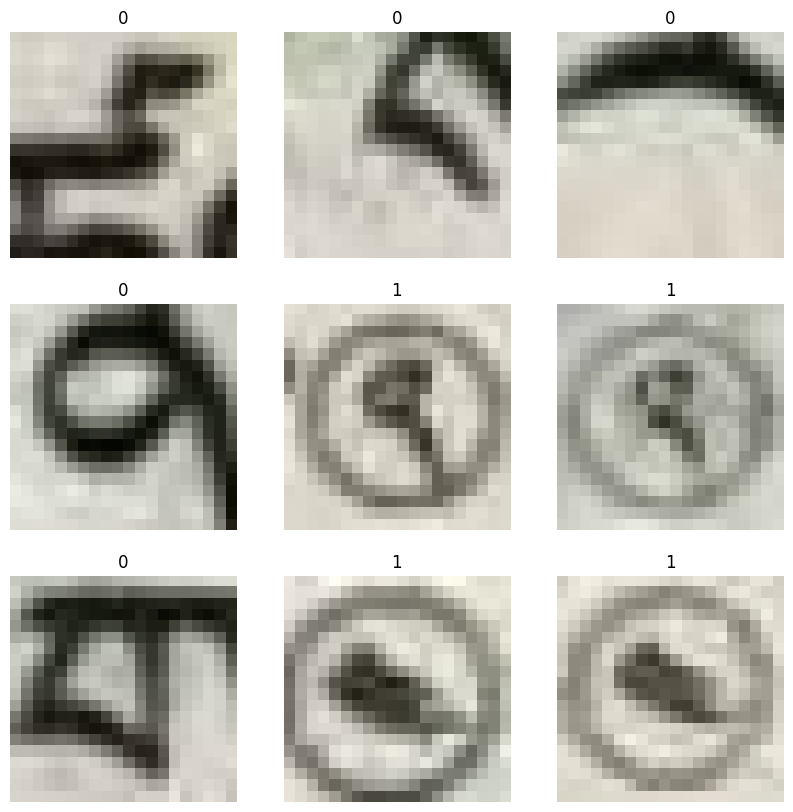

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [18]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build Model

In [24]:
def make_model(input_shape, num_classes):
    units = 1 if num_classes == 2 else num_classes
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Rescaling(1.0 / 255),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(units, activation=None),
        ]
    )
    return model

model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,969 (78.00 KB)

 Trainable params: 19,969 (78.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [25]:
epochs = 25

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint("./models/note_classifier/save_at_{epoch}.keras"),
]

In [27]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

In [28]:
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6377 - loss: 0.6668 - val_acc: 0.6553 - val_loss: 0.5646
Epoch 2/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.6441 - loss: 0.5354 - val_acc: 0.7323 - val_loss: 0.3832
Epoch 3/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8114 - loss: 0.3569 - val_acc: 0.9113 - val_loss: 0.2296
Epoch 4/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9295 - loss: 0.2255 - val_acc: 0.9805 - val_loss: 0.1408
Epoch 5/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9741 - loss: 0.1450 - val_acc: 0.9866 - val_loss: 0.0910
Epoch 6/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9853 - loss: 0.0982 - val_acc: 0.9888 - val_loss: 0.0667
Epoch 7/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9854 - loss: 0.0769 - val_acc: 0.9916 - val_loss: 0.0508
Epoch 8/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9864 - loss: 0.0701 - val_acc: 0.9927 - val_loss: 0.0465
Epoch 9/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9878

## Inference

In [29]:
gen_image_path = (config.NOTE_CLASSIFIER_TRAINING_DATA / "todo").iterdir()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Note: 0.03%


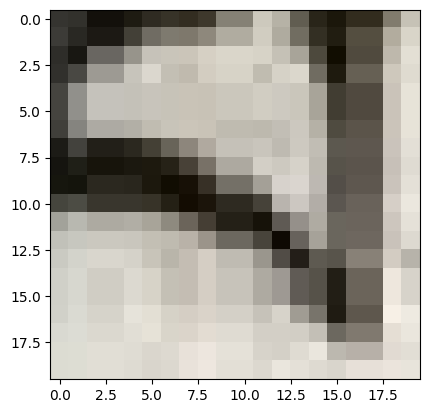

In [70]:
image_path = next(gen_image_path)
img = keras.utils.load_img(str(image_path), target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"Note: {100 * score:.2f}%")

In [72]:
model_path = Path("models") / "note_classifier" / "note_classifier.keras"
model.save(model_path)